# Fast Single Image Super-Resolution Using a New Analytical Solution :

### Ali MOURTADA - Anas ESSOUNAINI 

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fft2, ifft2
from scipy.ndimage import gaussian_filter
from skimage import io
from scipy.ndimage.filters import convolve
import cv2
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from time import time

In [ ]:
PATH = r'C:/Users/essou/Desktop/my_projects/image-super-resolution/images/'PATH = r'C:/Users/essou/Desktop/my_projects/image-super-resolution/images/'

## Important functions : 

Here are some important functions that will be useful in the implementation of the two algorithms.

In [2]:
def gauss2D_Kernel(shape=(3,3),sigma=0.5):
    '''
    INPUT:
        shape : The shape of the blurring kernel (Tuple)
        sigma : The standard deviation of the Gaussian Kernel (Float)
    OUTPUT:
        h : The Gaussian Blurring Kernel
    '''
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [3]:
def segmented_process(M, blk_size, fun=None):
    '''
    INPUT:
        M : The input matrix (Array)
        blk_size : The size of the blocks to be processed (Tuple)
        fun : The function to be applied to each block (function)
    OUTPUT:
        M_res : The resulting matrix (Array)
    '''
    rows = []
    for i in range(0, M.shape[0], blk_size[0]):
        cols = []
        for j in range(0, M.shape[1], blk_size[1]):
            cols.append(fun(M[i:i+blk_size[0], j:j+blk_size[1]]))
        rows.append(np.concatenate(cols, axis=1))
    M_res = np.concatenate(rows, axis=0)
    return M_res

In [4]:
def blockMM(nr,nc,Nb,x1):
    '''
    INPUT:
        x1 : The input HR Image (Array)
        nr,nc : The size of the LR Image (int)
        Nb : scale factor Nb = dr*dc (int)
    OUTPUT:
        x : The resulting decimated matrix of size (nr,nc) (Array)
    '''
    myfun = lambda block:block.reshape((1,nr*nc))
    x1 = segmented_process(x1, blk_size=(nr,nc), fun=myfun)
    x1 = x1.reshape((Nb,nr*nc))
    x1 = x1.sum(axis = 0)
    x = x1.reshape((nr,nc))
    
    return x

In [5]:
def ISNR(y,x,x_hat):
    return 10*np.log10(np.linalg.norm(x-y,'fro')**2/np.linalg.norm(x-x_hat,'fro')**2)

def PSNR(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

## Analytical Solution and Algorithm 1 :

The first algorithm we will implement is the analytical based Fast Super-Resolution algorithm ``INVLS``.
The implementation requires an operator **H** which will be derived from a Blurring Kernel **B** using the function ``HXconv`` below.

In [6]:
def HXconv(x,B):
    '''
    INPUT:
        x : Input High Resolution Image (Array)
        B : Blurring Kernel (Array)
    OUTPUT:
        BF : The Fourier Transform of the Blurring Kernel (Array)
        BFC : Conj(BF) (Array)
        B2F :abs(BF)**2 (Array)
        y : The blurred image 
    '''
    m,n = x.shape
    m0,n0 = B.shape
    
    Bpad = np.zeros((m,n))
    Bpad[int((m-m0)/2):int((m+m0)/2),int((n-n0)/2):int((n+n0)/2)] = B
    Bpad = fftshift(Bpad)
    
    BF = fft2(Bpad)
    BCF = np.conj(BF)
    B2F = np.abs(BF)**2

    y = np.real(ifft2(BF*fft2(x)))
    
    return BF,BCF,B2F,y

This is the implementation of the **FSR Algorithm**.

In [7]:
def INVLS(FB,FBC,F2B,FR,tau,Nb,nr,nc):
    '''
    INPUT:
        FB : Fourier transform of the blurring kernel B (Array)
        FBC : conj(FB) (Array)
        F2B : abs(FB)**2 (Array)
        FR : Fourier transform of R (Array)
        Nb : scale factor Nb = dr*dc (int)
        nr,nc : size of the observation (int)
    OUTPUT:
        Xest : Analytical solution (Array)
    '''
    x1 = FB*FR
    FBR = blockMM(nr,nc,Nb,x1)
    invW = blockMM(nr,nc,Nb,F2B)
    invWBR = FBR/(invW + tau*Nb)
    myfun = lambda block:block*invWBR
    FCBinvWBR = segmented_process(FBC, blk_size=(nr,nc), fun=myfun)
    FX = (FR-FCBinvWBR)/(tau)
    Xest = np.real(ifft2(FX))
    
    return Xest

## Experiments on Gray Scale images :

In this section, we will conduct some experiments on two gray scale images (Lena and Barbara).

### Test on Lena :

In [8]:
lena = io.imread(os.path.join(PATH, 'lena.bmp', ''))

In [9]:
refl = lena    # The High Resolution image
B = gauss2D_Kernel(shape=(20,20),sigma=3)  #The Gaussian Kernek
FB,FBC,F2B,Bx = HXconv(refl,B)
N = refl.shape[0]*refl.shape[1]
Psig  = np.linalg.norm(Bx,'fro')**2/N
BSNRdb = 40
sigma = np.linalg.norm(Bx-np.mean(Bx),'fro')/np.sqrt(N*10**(BSNRdb/10))
m,n = refl.shape

y = Bx + sigma*np.random.randn(m,n) # Here we create the noisy low resolution image from the HR image
FY = fft2(y)

d = 2
dr,dc = d,d
Nb = dr*dc

y = y[::dr,::dc]      #Here we perform the decimation
reflp = refl[::dr,::dc]

t = time()
yinp = cv2.resize(y,(d*y.shape[1],d*y.shape[0]),interpolation=cv2.INTER_CUBIC)  #Here we compute the bicubic interpolation
print(time() - t)

0.03600168228149414


In [10]:
## L2 norm Super-resolution with Analytical solution
taup = 2e-3
tau = taup*sigma**2
nr,nc = y.shape
m = nr*nc
nrup = nr*d
ncup = nc*d

In [11]:
## xp= refl
xp = yinp
STy = np.zeros((nrup,ncup))
STy[::d,::d] = y
FR = FBC*fft2(STy) + fft2(2*tau*xp)


t = time()
Xest_analytic = INVLS(FB,FBC,F2B,FR,2*tau,Nb,nr,nc)
print(time() - t)

0.09795188903808594


In [12]:
print("ISNR : " + str(ISNR(yinp,refl,Xest_analytic)))
print("PSNR : " + str(PSNR(refl,Xest_analytic)))
print("PSNR with bicubic: " + str(PSNR(yinp,refl)))

ISNR : 3.3621223890327294
PSNR : 29.29440305447496
PSNR with bicubic: 25.932280665442224


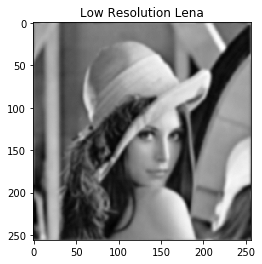

In [13]:
plt.imshow(y, cmap = 'gray')
plt.title("Low Resolution Lena")
plt.show()

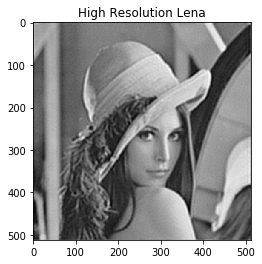

In [14]:
plt.imshow(Xest_analytic, cmap = 'gray')
plt.title("High Resolution Lena")
plt.show()

In [15]:
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\low_lena.png',y/256)
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_lena_analytic.png',Xest_analytic/256)
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_lena_bicubic.png',yinp/256)

### Test on Barbara :

In [16]:
barbara = io.imread(os.path.join(PATH, 'lena.bmp', '')) io.imread(os.path.join(PATH, 'barbara.bmp', ''))

In [17]:
refl = barbara    # The High Resolution image
B = gauss2D_Kernel(shape=(20,20),sigma=3)  #The Gaussian Kernek
FB,FBC,F2B,Bx = HXconv(refl,B)
N = refl.shape[0]*refl.shape[1]
Psig  = np.linalg.norm(Bx,'fro')**2/N
BSNRdb = 40
sigma = np.linalg.norm(Bx-np.mean(Bx),'fro')/np.sqrt(N*10**(BSNRdb/10))
m,n = refl.shape

y = Bx + sigma*np.random.randn(m,n) # Here we create the noisy low resolution image from the HR image
FY = fft2(y)

d = 2
dr,dc = d,d
Nb = dr*dc

y = y[::dr,::dc]      #Here we perform the decimation
reflp = refl[::dr,::dc]

t = time()
yinp = cv2.resize(y,(d*y.shape[1],d*y.shape[0]),interpolation=cv2.INTER_CUBIC)  #Here we compute the bicubic interpolation
print(time() - t)

0.002997875213623047


In [18]:
## L2 norm Super-resolution with Analytical solution
taup = 2e-3
tau = taup*sigma**2
nr,nc = y.shape
m = nr*nc
nrup = nr*d
ncup = nc*d

In [19]:
## xp= refl
xp = yinp
STy = np.zeros((nrup,ncup))
STy[0:-1:d,0:-1:d] = y
FR = FBC*fft2(STy) + fft2(2*tau*xp)

t = time()
Xest_analytic = INVLS(FB,FBC,F2B,FR,2*tau,Nb,nr,nc)
print(time() - t)

0.14292025566101074


In [20]:
print("ISNR : " + str(ISNR(yinp,refl,Xest_analytic)))
print("PSNR : " + str(PSNR(refl,Xest_analytic)))
print("PSNR with bicubic: " + str(PSNR(yinp,refl)))

ISNR : 1.02246104812561
PSNR : 23.87811898420189
PSNR with bicubic: 22.855657936076284


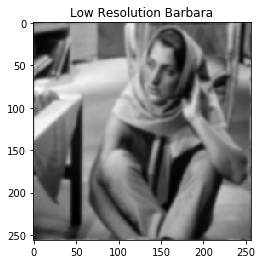

In [21]:
plt.imshow(y, cmap = 'gray')
plt.title("Low Resolution Barbara")
plt.show()

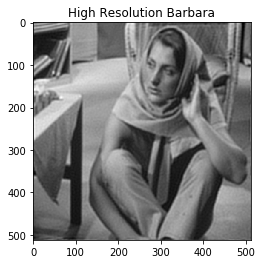

In [22]:
plt.imshow(Xest_analytic, cmap = 'gray')
plt.title("High Resolution Barbara")
plt.show()

In [23]:
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\low_barbara.png',y/256)
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_barbara_analytic.png',Xest_analytic/256)
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_barbara_bicubic.png',yinp/256)

### Test on another image : 

Here we try to test the algorithm on a colored image. We will crop a part of the image and try to reconstruct a HR image from the cropped image with the same size of the original image.

In [24]:
image = io.imread('cible.jpeg')
r,c = image.shape[0:2]

start_1,start_2 = 250,120
dr,dc = 4,4
crop = image[start_1:start_1+r//dr,start_2:start_2+c//dc]

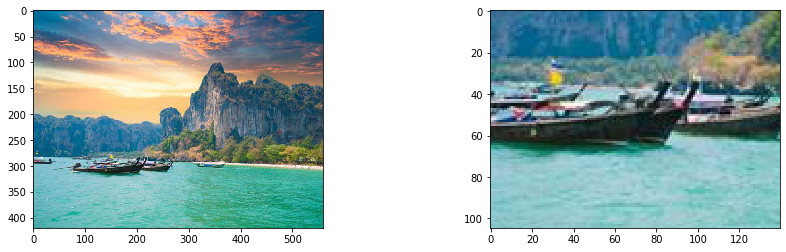

In [25]:
plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(crop)

plt.show()

In [26]:
B = gauss2D_Kernel(shape=(5,5),sigma=3)
FB,FBC,F2B,Bx = HXconv(rgb2gray(image),B)
N = 512*512
Psig  = np.linalg.norm(Bx,'fro')**2/N
BSNRdb = 40
sigma = np.linalg.norm(Bx-np.mean(Bx),'fro')/np.sqrt(N*10**(BSNRdb/10))
m,n = 512,512
FY = fft2(crop)

Nb = dr*dc

yinp = cv2.resize(crop,(dc*crop.shape[1],dr*crop.shape[0]),interpolation=cv2.INTER_CUBIC)

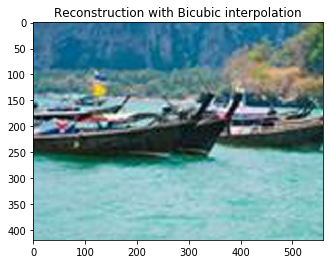

In [27]:
plt.imshow(yinp)
plt.title("Reconstruction with Bicubic interpolation")
plt.show()

In [28]:
## L2 norm Super-resolution with Analytical solution
taup = 2e-3
tau = taup*sigma**2
nr,nc = crop.shape[0:2]
m = nr*nc
nrup = nr*dr
ncup = nc*dc

In [29]:
#We perform the FSR on each RGB channel
xp = yinp
X = np.zeros(image.shape)
for i in range(crop.shape[2]):
    STy = np.zeros((nrup,ncup))
    STy[0:-1:dr,0:-1:dc] = crop[:,:,i]
    FR = FBC*fft2(STy) + fft2(2*tau*xp[:,:,i])

    Xest_analytic = INVLS(FB,FBC,F2B,FR,2*tau,Nb,nr,nc)
    a = Xest_analytic + np.abs(np.amin(Xest_analytic))
    X[:,:,i] = a/np.amax(a)

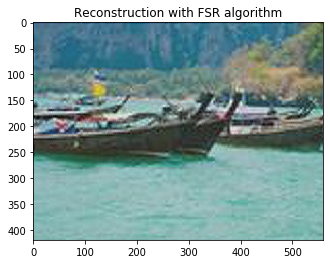

In [30]:
plt.imshow(X)
plt.title("Reconstruction with FSR algorithm")
plt.show()

## Iterative solution with direct ADMM algorithm and $l_2$-regularization:

In this section we will implement the Iterative algorithm with the $l_2$-regularization (ADMM). We will test it on the same two images.

### Test on Lena :

In [31]:
refl = lena
B = gauss2D_Kernel(shape=(20,20),sigma=3)
FB,FBC,F2B,Bx = HXconv(refl,B)
N = len(refl)*len(refl[0])
Psig  = np.linalg.norm(Bx,'fro')**2/N
BSNRdb = 40
sigma = np.linalg.norm(Bx-np.mean(Bx),'fro')/np.sqrt(N*10**(BSNRdb/10))
m,n = refl.shape
y = Bx + sigma*np.random.randn(m,n)
FY = fft2(y)

d = 2
dr,dc = d,d
Nb = dr*dc

y = y[::dr,::dc]
reflp = refl[::dr,::dc]
yinp = cv2.resize(y,(d*y.shape[1],d*y.shape[0]),interpolation=cv2.INTER_CUBIC)

taup = 2e-3
tau = taup*sigma**2
nr,nc = y.shape
m = nr*nc
nrup = nr*dr
ncup = nc*dc

xp = yinp
STy = np.zeros((nrup,ncup))
STy[0:-1:d,0:-1:d] = y
FR = FBC*fft2(STy) + fft2(2*tau*xp)

In [32]:
maxiter = 100
tolA = 1e-4

X = yinp
BX = ifft2(FB*fft2(X))
resid =  ifft2(y - BX[::dr,::dc])
prev_f = 0.5*(np.linalg.norm(resid,'fro')**2 + tau*np.sum(np.abs(X-xp)))

mu = 0.01
nr,nc = y.shape

objective = np.zeros(maxiter)
objective[0] = prev_f
ISNR_admmSet_lena = np.zeros(maxiter)
PSNR_admmSet_lena = np.zeros(maxiter)

nrup = nr*dr
ncup = nc*dc
STytemp = np.ones((nrup,ncup))
STytemp[::dr,::dc] =y 
ind1 = np.where(STytemp-STy==1)
ind2 = np.where(STytemp-STy==0)

In [33]:
t0 = time()
gam = tau/mu
X = yinp
U = X
D = np.zeros((nrup,ncup))

for i in range(maxiter-1):
    # update X
    V = U-D
    Fb = FBC*fft2(V) + fft2(2*gam*xp)
    FX = Fb/(F2B + 2*gam);
    X = ifft2(FX)
    # update u
    rr = mu*(ifft2(FB*FX) + D)   
    temp1 = rr[ind1]/mu
    temp2 = (rr[ind2] + STy[ind2])/(1+mu)
    U[ind1] = temp1
    U[ind2] = temp2
    # update d
    D = D + (ifft2(FB*FX)-U)

    ISNR_admmSet_lena[i] = ISNR(yinp,refl,X)
    PSNR_admmSet_lena[i] = PSNR(refl,X)
    BX = ifft2(FB*fft2(X))
    resid =  ifft2(y - BX[::dr,::dc])
    objective[i+1] = 0.5*(np.linalg.norm(resid,'fro')**2 + tau*np.sum(np.abs(X-xp)))

    if np.abs(objective[i+1]-objective[i])/objective[i] < tolA:
        break
            
print(time() - t0)

C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


29.83463406562805


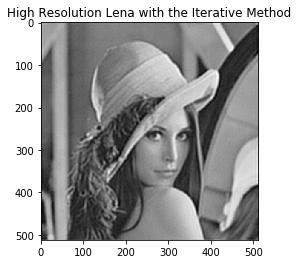

ISNR : 3.5432145927911076
PSNR : 29.12428757761171
PSNR with bicubic: 25.581072984820608


In [34]:
X_recovery = np.real(X)
plt.imshow(X_recovery, cmap = 'gray')
plt.title("High Resolution Lena with the Iterative Method")
plt.show()

print("ISNR : " + str(ISNR(yinp,refl,X_recovery)))
print("PSNR : " + str(PSNR(refl,X_recovery)))
print("PSNR with bicubic: " + str(PSNR(yinp,refl)))

In [35]:
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_lena_iter.png',X_recovery/256)

### Test on Barbara :

In [36]:
refl = barbara
B = gauss2D_Kernel(shape=(20,20),sigma=3)
FB,FBC,F2B,Bx = HXconv(refl,B)
N = len(refl)*len(refl[0])
Psig  = np.linalg.norm(Bx,'fro')**2/N
BSNRdb = 40
sigma = np.linalg.norm(Bx-np.mean(Bx),'fro')/np.sqrt(N*10**(BSNRdb/10))
m,n = refl.shape
y = Bx + sigma*np.random.randn(m,n)
FY = fft2(y)

d = 2
dr,dc = d,d
Nb = dr*dc

y = y[::dr,::dc]
reflp = refl[::dr,::dc]
yinp = cv2.resize(y,(d*y.shape[1],d*y.shape[0]),interpolation=cv2.INTER_CUBIC)

taup = 2e-3
tau = taup*sigma**2
nr,nc = y.shape
m = nr*nc
nrup = nr*dr
ncup = nc*dc

xp = yinp
STy = np.zeros((nrup,ncup))
STy[0:-1:d,0:-1:d] = y
FR = FBC*fft2(STy) + fft2(2*tau*xp)

In [37]:
maxiter = 100
tolA = 1e-4

X = yinp
BX = ifft2(FB*fft2(X))
resid =  ifft2(y - BX[::dr,::dc])
prev_f = 0.5*(np.linalg.norm(resid,'fro')**2 + tau*np.sum(np.abs(X-xp)))

muVec = 0.01
nr,nc = y.shape

objective = np.zeros(maxiter)
objective[0] = prev_f
ISNR_admmSet_barbara = np.zeros(maxiter)
PSNR_admmSet_barbara = np.zeros(maxiter)

nrup = nr*dr
ncup = nc*dc
STytemp = np.ones((nrup,ncup))
STytemp[::dr,::dc] =y 
ind1 = np.where(STytemp-STy==1)
ind2 = np.where(STytemp-STy==0)

In [38]:
t0 = time()

gam = tau/mu
X = yinp
U = X
D = np.zeros((nrup,ncup))

for i in range(maxiter-1):
    # update X
    V = U-D
    Fb = FBC*fft2(V) + fft2(2*gam*xp)
    FX = Fb/(F2B + 2*gam);
    X = ifft2(FX)
    # update u
    rr = mu*(ifft2(FB*FX) + D)   
    temp1 = rr[ind1]/mu
    temp2 = (rr[ind2] + STy[ind2])/(1+mu)
    U[ind1] = temp1
    U[ind2] = temp2
    # update d
    D = D + (ifft2(FB*FX)-U)

    ISNR_admmSet_barbara[i] = ISNR(yinp,refl,X)
    PSNR_admmSet_barbara[i] = PSNR(refl,X)
    BX = ifft2(FB*fft2(X))
    resid =  ifft2(y - BX[::dr,::dc])
    objective[i+1] = 0.5*(np.linalg.norm(resid,'fro')**2 + tau*np.sum(np.abs(X-xp)))

    if np.abs(objective[i+1]-objective[i])/objective[i] < tolA:
        break
            
print(time() - t0)

C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


29.61320662498474


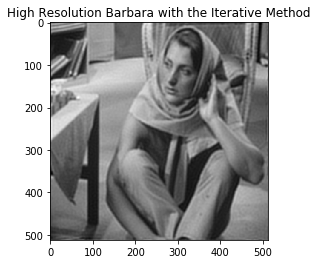

ISNR : 1.1286178672085612
PSNR : 23.843248207176725
PSNR with bicubic: 22.71463033996816


In [39]:
X_recovery = np.real(X)
plt.imshow(X_recovery, cmap = 'gray')
plt.title("High Resolution Barbara with the Iterative Method")
plt.show()

print("ISNR : " + str(ISNR(yinp,refl,X_recovery)))
print("PSNR : " + str(PSNR(refl,X_recovery)))
print("PSNR with bicubic: " + str(PSNR(yinp,refl)))

In [40]:
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_barbara_iter.png',X_recovery/256)

### Results :

C:\Users\ali-_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


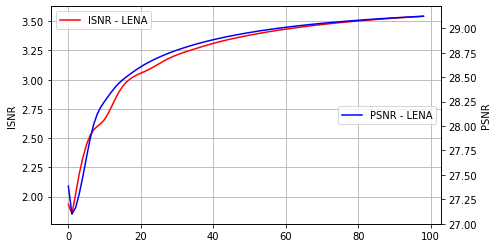

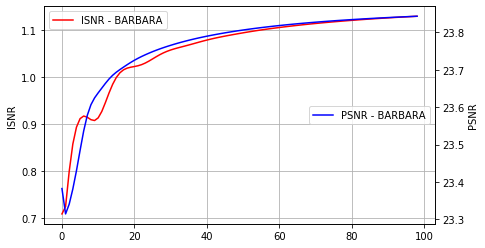

In [42]:
figlena = plt.figure(figsize=(7,4))

plt.grid()
ax1 = plt.subplot(1,1,1)
ax1.plot(range(maxiter-1),ISNR_admmSet_lena[:-1], label = 'ISNR - LENA', color = 'r')
ax1.set_ylabel("ISNR")
plt.legend(loc = 0)

ax2 = ax1.twinx()
ax2.plot(range(maxiter-1),PSNR_admmSet_lena[:-1], label = 'PSNR - LENA', color = 'b')
ax2.set_ylabel("PSNR")
plt.legend(loc = 7)

plt.xlabel("Number of iterations")
plt.show()

figbarbara = plt.figure(figsize=(7,4))
ax3 = plt.subplot(1,1,1)
plt.grid()
ax3.plot(range(maxiter-1),ISNR_admmSet_barbara[:-1], label = 'ISNR - BARBARA', color = 'r')
ax3.set_ylabel("ISNR")
plt.legend(loc = 0)

ax4 = ax3.twinx()
ax4.plot(range(maxiter-1),PSNR_admmSet_barbara[:-1], label = 'PSNR - BARBARA', color = 'b')
ax4.set_ylabel("PSNR")
plt.legend(loc = 7)
plt.xlabel("Number of iterations")
plt.show()

figlena.savefig(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\SNRlena.png')
figbarbara.savefig(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\SNRbarbara.png')

In [ ]:
#io.imsave(r'C:\Users\ali-_\Desktop\SDIA\TraitementImages\high_barbara_iterative.png',X_recovery/256)